In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-08-07 10:00:44.855672: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 10:00:45.043461: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 10:00:45.821433: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 10:00:46.570253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 10:00:47.287200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Num GPUs Available:  0


2024-08-07 10:01:16.536244: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


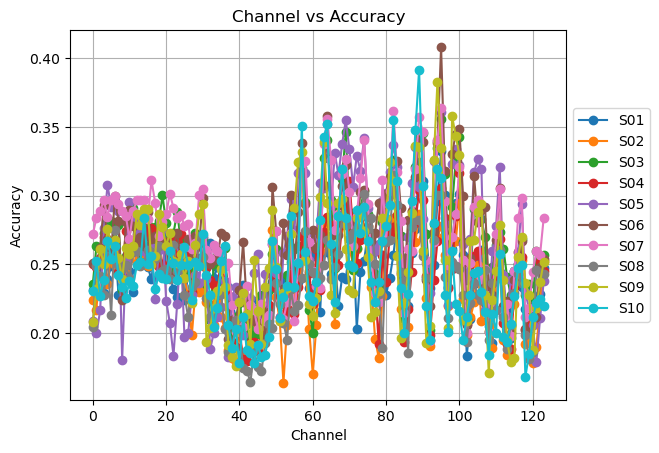

In [32]:
class MatClassRSA:
    class Preprocessing:
        @staticmethod
        def shuffleData(X, Y):
            idx = np.random.permutation(len(Y))
            return X[:, :, idx], Y[idx]

    class Classification:
        @staticmethod
        def crossValidateMulti(X, Y, channels=[96, 32]):
            # Prepare the data
            feature_vector = np.concatenate([X[ch_num, :, :] for ch_num in channels], axis=0).T
            X_train, X_test, Y_train, Y_test = train_test_split(feature_vector, Y, test_size=0.3)

            # Encode labels to one-hot vectors
            encoder = LabelEncoder()
            Y_train = encoder.fit_transform(Y_train)
            Y_test = encoder.transform(Y_test)
            Y_train = to_categorical(Y_train)
            Y_test = to_categorical(Y_test)

            # Build neural network model
            model = Sequential()
            model.add(Dense(512, input_dim=feature_vector.shape[1], activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(256, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(128, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(Y_train.shape[1], activation='softmax'))

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Train the model with early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), callbacks=[early_stopping])

            # Evaluate the model
            Y_pred = np.argmax(model.predict(X_test), axis=1)
            Y_test_labels = np.argmax(Y_test, axis=1)
            accuracy = accuracy_score(Y_test_labels, Y_pred)

            return accuracy

def load_data(pNum):
    X, labels6, labels72 = [], [], []
    if type(pNum) == int:
        pNum = [pNum]
    for i in pNum:
        baseFn = f'S{i:02d}.mat'
        data = sio.loadmat("./Data/" + baseFn)
        X.append(data['X'])
        labels6.append(data['labels6'])
        labels72.append(data['labels72'])
    X = np.concatenate(X, axis=2)
    labels6 = np.concatenate(labels6)
    labels72 = np.concatenate(labels72)
    return X, labels6, labels72, data['t'], data['fs']

def main(pNum, nCategories=6, channels=None):
    if channels is None:
        channels = range(124)  # Testing all 124 channels

    data_filename = 'patient_accurices_nCategories'+str(nCategories)+'.pkl'
    try:
        with open(data_filename, 'rb') as f:
            patient_accurices = pickle.load(f)
    except:
        patient_accurices = {}
    
    if pNum == 0: # Run on all patients
        pNum_range = list(range(1,11))
    else:
        if type(pNum)==int:
            pNum_range = [pNum]
        else:
            pNum_range = pNum

    for pNum in pNum_range:
        if pNum in patient_accurices.keys():
            uncalculated_channels = [item for item in channels if item not in patient_accurices[pNum].keys()]
            if uncalculated_channels is not []:
                X, labels6, labels72, t, fs = load_data(pNum)
                RSA = MatClassRSA()
                Y = labels6 if nCategories == 6 else labels72
                Xr, Yr = RSA.Preprocessing.shuffleData(X, Y)

                accuracies = patient_accurices[pNum]
                for ch in uncalculated_channels:
                    print(f'~ ~ Performing classification on channel {ch} ~ ~ ...')
                    accuracy = RSA.Classification.crossValidateMulti(Xr, Yr.ravel(), [ch])
                    accuracies[ch] = accuracy
                    if ch % 62 == 0:
                        # Periodic saving of data
                        patient_accurices[pNum] = accuracies
                        with open(data_filename, 'wb') as f:
                            pickle.dump(patient_accurices, f)
                
                # Periodic saving of data
                patient_accurices[pNum] = accuracies
                with open(data_filename, 'wb') as f:
                    pickle.dump(patient_accurices, f)

        else:
            X, labels6, labels72, t, fs = load_data(pNum)
            RSA = MatClassRSA()
            Y = labels6 if nCategories == 6 else labels72
            Xr, Yr = RSA.Preprocessing.shuffleData(X, Y)

            accuracies = {}
            for ch in channels:
                print(f'~ ~ Performing classification on channel {ch} ~ ~ ...')
                accuracy = RSA.Classification.crossValidateMulti(Xr, Yr.ravel(), [ch])
                accuracies[ch] = accuracy
                if ch % 62 == 0:
                    # Periodic saving of data
                    patient_accurices[pNum] = accuracies
                    with open(data_filename, 'wb') as f:
                        pickle.dump(patient_accurices, f)
            
            # Periodic saving of data
            patient_accurices[pNum] = accuracies
            with open(data_filename, 'wb') as f:
                pickle.dump(patient_accurices, f)
    

    # Plotting accuracy for each channel
    plt.figure()
    for pNum, accuracies in {key: patient_accurices[key] for key in pNum_range if key in patient_accurices}.items():
        plt.plot(channels, list(map(accuracies.get, channels)), marker='o', linestyle='-', label=f'S{pNum:02d}')
    plt.xlabel('Channel')
    plt.ylabel('Accuracy')
    plt.title('Channel vs Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('./Figures/S' + str(pNum_range)+"_nCategories"+str(nCategories)+'_accuracy_per_channel.png')
    plt.show()

    with open(data_filename, 'wb') as f:
        pickle.dump(patient_accurices, f)

    return patient_accurices

if __name__ == "__main__":
    pNum = 0
    nCategories = 6
    main(pNum, nCategories, range(124))  # Test all 124 channels

In [29]:
with open('patient_accurices.pkl', 'rb') as f:
    patient_accurices = pickle.load(f)

# patient_accurices